In [0]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.pandas as ps
from math import *

In [0]:
spark = SparkSession.builder.master("local[*]").appName("Datamanipulation").getOrCreate()

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
# read our data - lives in a csv file

df = spark.read.table("eu_superstore_csv")
df.printSchema()

root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Ship Date: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: float (nullable = true)
 |-- Profit: float (nullable = true)



In [0]:
# how many rows of the EU Superstore dataset have the country being France
df.filter(df["Country"]=="France").count()

Out[220]: 2827

In [0]:
# of those, how many are profitable?
df.filter((df["Country"]=="France")&(df["Profit"]>0)).count()

Out[221]: 2329

In [0]:
# how many different discount brackets exist? what are they?
df.select("Discount").distinct().count()
df.select("Discount").distinct().show()

+--------+
|Discount|
+--------+
|    0.15|
|    0.45|
|     0.1|
|    0.35|
|     0.6|
|     0.5|
|    0.85|
|     0.3|
|     0.4|
|     0.8|
|     0.2|
|    0.65|
|     0.0|
|     0.7|
+--------+



In [0]:
# let's see the total profit by discount bracket, make sure they are ordered by 
df.groupBy("Discount").agg({"Profit":"sum"}).withColumnRenamed("sum(Profit)","Total Profit").orderBy("Discount", ascending=False).show()

+--------+-------------------+
|Discount|       Total Profit|
+--------+-------------------+
|    0.85| -3068.657958984375|
|     0.8|-460.28399658203125|
|     0.7| -5496.764984130859|
|    0.65| -6221.965492248535|
|     0.6| -20517.45601272583|
|     0.5| -96632.11525454745|
|    0.45|-1103.1914978027344|
|     0.4|-21346.427940785885|
|    0.35| -9122.649054527283|
|     0.3| -758.4209960997105|
|     0.2|  2189.549998320639|
|    0.15| 24677.563616948202|
|     0.1| 126884.03075543372|
|     0.0|  383806.5302368067|
+--------+-------------------+



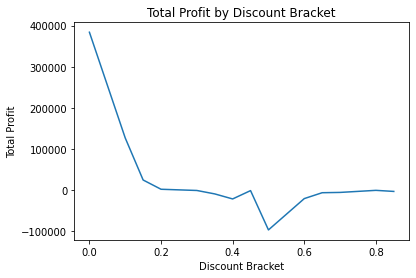

In [0]:
# what is the value after which we should stop offering discount?

from matplotlib import pyplot as plt

#Based on the data generated on the previous cell, anything above 30% discount seems to be damaging the business, not absolute however, as wee see huge loses in 40% but 80% has minor loss.

df_1=df.groupBy("Discount").agg({"Profit":"sum"}).withColumnRenamed("sum(Profit)","Total Profit").orderBy("Discount", ascending=False)
df_viz=df_1.toPandas()

plt.plot(df_viz["Discount"], df_viz["Total Profit"])
plt.xlabel("Discount Bracket")
plt.ylabel("Total Profit")
plt.title("Total Profit by Discount Bracket")
plt.show()

#Now looking both the table before and the chart below, most damaging discounts are between 40% and 60%, the peak loss being 50%!

In [0]:
# who are the top 5 most profitable customers
df.select("Customer Name","Profit").orderBy("Profit", ascending=False).limit(5).show()


+-----------------+-------+
|    Customer Name| Profit|
+-----------------+-------+
|    Patrick Jones|3979.08|
|Elpida Rittenbach|2476.44|
|  Mike Gockenbach|2461.32|
|     James Galang|2071.44|
|    Ellis Ballard|1989.54|
+-----------------+-------+



In [0]:
# get all the rows belonging to those 5 customer names: hint, you may need the collect method - how many rows are they?

top_5 = df.select("Customer Name","Profit").orderBy("Profit", ascending=False).limit(5)
customers = [x["Customer Name"] for x in top_5.collect()]
final = df.filter(df["Customer Name"].isin(customers))
final.count()

Out[226]: 54

In [0]:
# create a new column which is the value of the sale were there not discount applied. Hint: orginal = sales/(1-d)
df=df.withColumn("Sales without Disc", col("Sales")*(1+col("Discount")))
df.printSchema()

root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Ship Date: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: float (nullable = true)
 |-- Profit: float (nullable = true)
 |-- Sales without Disc: float (nullable = true)



In [0]:
# calculate the difference between sales and discount value

df = df.withColumn("Discount_amount", col("Sales without Disc") - col("Sales"))
df.select("Discount_amount","Sales","Discount").orderBy("Discount_amount", ascending=False).show()


+---------------+---------+--------+
|Discount_amount|    Sales|Discount|
+---------------+---------+--------+
|      1699.8298|  3399.66|     0.5|
|      1437.8853|  2875.77|     0.5|
|      1415.2126| 2830.425|     0.5|
|      1285.4324| 2570.865|     0.5|
|      1185.6936| 1824.144|    0.65|
|      1170.2233| 1950.372|     0.6|
|        1073.52|   2683.8|     0.4|
|      1071.9211| 3062.631|    0.35|
|      1068.5808| 2671.452|     0.4|
|        1035.45|   2070.9|     0.5|
|      1029.0961|  1715.16|     0.6|
|       991.5676| 1983.135|     0.5|
|       977.9885|2794.2524|    0.35|
|      954.73364| 1363.905|     0.7|
|         950.25|   1900.5|     0.5|
|       884.0449| 1473.408|     0.6|
|      870.68164| 1451.136|     0.6|
|       827.4358| 2364.102|    0.35|
|         824.22|  1648.44|     0.5|
|      807.43494|  1614.87|     0.5|
+---------------+---------+--------+
only showing top 20 rows



In [0]:
# how much money did we not gain due to the discounts - per discount bracket?
df.groupBy("Discount").agg({"Discount_amount":"sum"}).withColumnRenamed("sum(Discount_amount)","Total Loss").orderBy("Discount", ascending=False).show()

+--------+------------------+
|Discount|        Total Loss|
+--------+------------------+
|    0.85| 677.3157806396484|
|     0.8| 127.1327953338623|
|     0.7|2560.2257385253906|
|    0.65| 4276.879325866699|
|     0.6|15857.619043827057|
|     0.5| 91867.13257217407|
|    0.45|1145.8930053710938|
|     0.4|28034.811422348022|
|    0.35|18956.015533447266|
|     0.3|1841.1683654785156|
|     0.2| 8522.497813224792|
|    0.15|38448.193199157715|
|     0.1| 76241.22352743149|
|     0.0|               0.0|
+--------+------------------+



In [0]:
# find the discount bracket which made us not gain the most (dynamically)
df_loss=df.groupBy("Discount").agg({"Discount_amount":"sum"}).withColumnRenamed("sum(Discount_amount)","Total Loss").withColumn("Total Loss", round("Total Loss", 2))

df_loss.select("Discount", "Total Loss").orderBy("Total Loss", ascending=False).limit(1).show()


+--------+----------+
|Discount|Total Loss|
+--------+----------+
|     0.5|  91867.13|
+--------+----------+



In [0]:
# what would have been the total profit if we removed all orders from that discount group? 
df = df.join(df_loss, on="Discount", how="left")
max_loss = df.select("Discount", "Total Loss").orderBy("Total Loss", ascending=False).limit(1)
loss_discount = max_loss.select("Discount").collect()[0][0]
profit_without_loss = df.filter(df.Discount != loss_discount).agg({"Profit":"sum"}).collect()[0][0]
print(profit_without_loss)

469461.85667362204


In [0]:
#how much more (or less) profit is that?
a=df_loss.select("Total Loss").orderBy("Total Loss", ascending=False).limit(1)
f_a = float(a.first()[0])
print(f"The profit with discount used is {profit_without_loss-f_a} and is less by {f_a}")

The profit with discount used is 377594.72667362203 and is less by 91867.13


In [0]:
# create a temporary table for our superstore table in sql


In [0]:
# use an SQL query to count the number of rows


In [0]:
# Use an SQL query to calculate the profit ratio for each country: hint, ratio is sum(profit)/sum(sales)


In [0]:
# is the country with the largest profit ratio, the country with the largest profit?

